In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#hide
from collections import Counter
from statistics import mean, median, stdev
import numpy as np

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [3]:
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [4]:
df = pd.read_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\df.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,response,context 4,context 3,context 2,context 1,context 0
0,The treatment for arrhythmias can vary dependi...,"If it is an arrhythmia, what are the available...","Based on your symptoms, it's possible that you...",I've been feeling lightheaded and my heartbeat...,Hello. How can I assist you today?,"Hi, Medi."
1,While most cases of arrhythmias are not seriou...,Are arrhythmias a serious condition?,Your symptoms are indeed consistent with arrhy...,I've been experiencing palpitations and shortn...,Hello. How can I assist you today?,"Hi, Medi."
2,"Certain arrhythmias can be life-threatening, e...","If it is an arrhythmia, can it be life-threate...","Based on your symptoms, it's possible that you...",I've been having chest pain and feeling a paus...,Hello. How can I assist you today?,"Hi, Medi."
3,"Common causes of palpitations include anxiety,...",What are some common causes of palpitations?,Palpitations can be caused by various factors....,I've been experiencing palpitations lately. Sh...,Hello! How can I assist you today?,"Hi, Medi."
4,While most cases of arrhythmias are not seriou...,Are arrhythmias life-threatening?,Symptoms of arrhythmias can range from palpita...,What are the symptoms of arrhythmias?,Of course! I'm here to help. What would you li...,"Hey, Medi. I have a question about arrhythmias."


In [5]:
print(df.count())

response     7298
context 4    7266
context 3    7272
context 2    7300
context 1    7303
context 0    7303
dtype: int64


In [6]:
# Count the number of missing values
missing_values_count = df.isna().sum()

# Display the count of missing values
print(missing_values_count)

response      5
context 4    37
context 3    31
context 2     3
context 1     0
context 0     0
dtype: int64


In [7]:
df = df.dropna()
df.count()

response     7263
context 4    7263
context 3    7263
context 2    7263
context 1    7263
context 0    7263
dtype: int64

In [8]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [9]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

In [10]:
#collapse
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

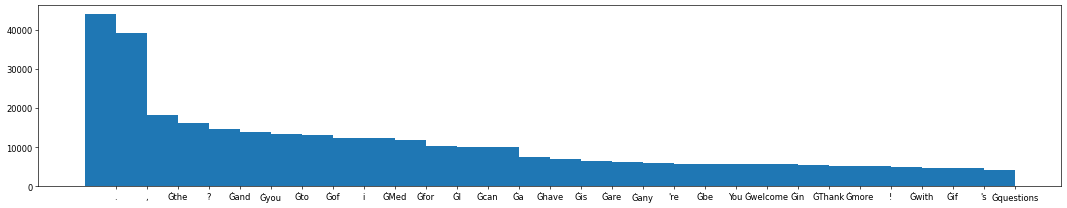

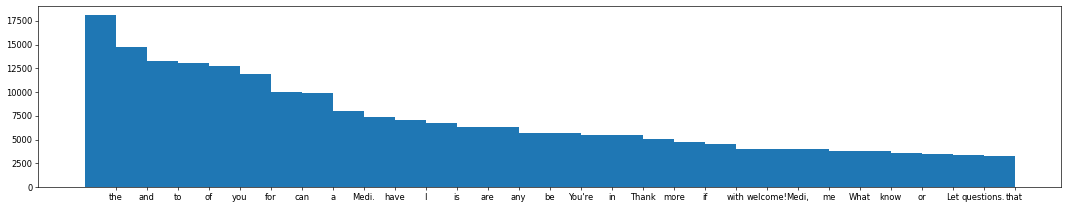

In [11]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [12]:
#collapse
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 107.79140850888062, Median: 107, Standard Deviation: 18.230526724133597, 90th Percentile: 192.0


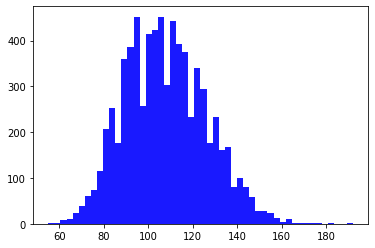

In [13]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)

# Train test split

In [1]:
from sklearn.model_selection import train_test_split

In [14]:
trn_df, val_df = train_test_split(df, test_size=0.1)
# trn_df, val_df = train_test_split(trn_df, test_size=0.07)
trn_df.count()

response     6536
context 4    6536
context 3    6536
context 2    6536
context 1    6536
context 0    6536
dtype: int64

In [34]:
trn_df.to_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\train_.csv')
# test_df.to_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\test.csv')
val_df.to_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\val_.csv')